In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from nltk import word_tokenize,sent_tokenize
import nltk
import re
from sklearn.model_selection import train_test_split
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# План

<p>Моя работа состоит из 4 частей:<p>
<p>1) Исследование данных<p>
<p>2) Решение задачи как Question Answering<p>
<p>3) Решение задачи как NER<p>
<p>4) Выяснение, какой результат лучше<p>


# Исследование данных

In [ ]:
train_df = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/dataset/train.json")
test_df = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/dataset/test.json")

In [ ]:
train_df.head(5)

,id,text,label,extracted_part
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...


In [ ]:
print(len(train_df))
print(len(test_df))

1799
318


In [ ]:
train_df['label'].value_counts()

обеспечение исполнения контракта        988
обеспечение гарантийных обязательств    811
Name: label, dtype: int64

In [ ]:
train_df['label'].value_counts(normalize = True)

обеспечение исполнения контракта        0.549194
обеспечение гарантийных обязательств    0.450806
Name: label, dtype: float64

<Axes: ylabel='label'>

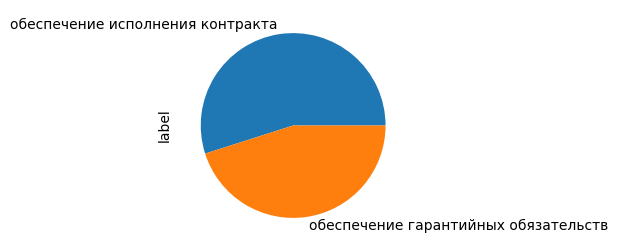

In [ ]:
train_df['label'].value_counts().plot.pie(figsize=(3,3))

Данные сбалансированы по label

Выделим 10 элементов обеспечение исполнения контракта и обеспечение гарантийных обязательств

In [ ]:
index_of_first_class = []
index_of_second_class = []
f = 0
s = 0
for i in range(len(train_df)):
    if train_df['label'][i] == "обеспечение исполнения контракта" and f<10:
        index_of_first_class.append(i)
        f+=1
    elif train_df['label'][i] == "обеспечение гарантийных обязательств" and s<10:
        index_of_second_class.append(i)
        s+=1

In [ ]:
for i in index_of_first_class:
    print(train_df['extracted_part'][i]['text'])

['Размер обеспечения исполнения контракта 6593.25 Российский рубль']
['Поставщик должен предоставить обеспечение исполнения контракта в размере 10 % от цены Контракта.']
['Размер обеспечения исполнения контракта 10.00%']
['Размер обеспечения исполнения контракта 10.00%']
['Размер обеспечения исполнения контракта 10.00%']
['Размер обеспечения исполнения контракта устанавливается в размере 5 (пять) процентов от цены, по которой заключается контракт и составляет ___']
['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта']
['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта']
['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта']
['Размер обеспечение исполнения контракта устанавливается от 0,5 % до 30 % начальной (максимальной) цены контракта']


In [ ]:
for i in index_of_second_class:
    print(train_df['extracted_part'][i]['text'])

['Размер обеспечения гарантийных обязательств 1597.60 Российский рубль']
['Размер обеспечения гарантийных обязательств 1% начальной (максимальной) цены контракта, что составляет 3 150,00 рублей.']
['Обеспечение гарантийных обязательств устанавливается в размере 5% процентов начальной (максимальной) цены контракта, что составляет 60 787']
['Размер обеспечения гарантийных обязательств 11599.38 Российский рубль']
['Размер обеспечения гарантийных обязательств по контракту предоставляется в размере _______ руб. (1 % от НМЦК).']
['Обеспечение гарантийных обязательств 5% от НМЦК.']
['Размер обеспечения гарантийных обязательств 2177.13 Российский рубль']
['']
['']
['']


Попробуем разбить по точкам текст на предолжения

In [ ]:
train_df['text'][index_of_second_class[0]]

'Извещение о проведении электронного аукциона для закупки №0153300066722000025 Общая информация Номер извещения 0153300066722000025 Наименование объекта закупки Приобретение жилого помещения для предоставления по договорам специализированного найма жилых помещений детям-сиротам, детям, оставшимся о помещения (жилого дома/квартиры) или его частей, нарушения требований технических регламентов, градостроительных регламентов, а также иных обязательных требований к процессу его эксплуатации либо вследствие ненадлежащего его ремонта, проведенного самим Покупателем или привлеченными им третьими лицами. Требования к гарантии производителя товара Покупатель вправе предъявить Продавцу требования в связи с ненадлежащим качеством жилого помещения (жилого дома/квартиры) при условии, если такое качество выявлено в течение гарантийного срока. Срок, на который предоставляется гарантия Гарантийный срок на жилое помещение (жилой дом/квартиру), в том числе на технологическое и инженерное оборудование, вх

In [ ]:
train_df['extracted_part'][index_of_second_class[0]]

{'text': ['Размер обеспечения гарантийных обязательств 1597.60 Российский рубль'],
 'answer_start': [1297],
 'answer_end': [1365]}

In [ ]:
sent_of_first_text = sent_tokenize(train_df['text'][index_of_second_class[0]])

In [ ]:
sent_of_first_text[0]

'Извещение о проведении электронного аукциона для закупки №0153300066722000025 Общая информация Номер извещения 0153300066722000025 Наименование объекта закупки Приобретение жилого помещения для предоставления по договорам специализированного найма жилых помещений детям-сиротам, детям, оставшимся о помещения (жилого дома/квартиры) или его частей, нарушения требований технических регламентов, градостроительных регламентов, а также иных обязательных требований к процессу его эксплуатации либо вследствие ненадлежащего его ремонта, проведенного самим Покупателем или привлеченными им третьими лицами.'

Нельзя сделать разделение по предложениям так как нету точек

Посчитаем статистики средняя длина текстов и Количество пустых фрагментов

In [ ]:
from collections import Counter

In [ ]:
empty_indexes = []
sen_lens = []
num_of_sen_in_fragment = []
for i in range(len(train_df)):
    extracted_text = train_df['extracted_part'][i]
    if extracted_text['answer_start'][0] == 0 and extracted_text['answer_end'][0] == 0:
        empty_indexes.append(i)

    sen_lens.append(len(train_df['text'][i]))

In [ ]:
print(f"Средняя длина текстов = {np.mean(sen_lens)}")
print(f"Количество пустых фрагментов = {len(empty_indexes)}")


Средняя длина текстов = 2301.4963868816008
Количество пустых фрагментов = 307


Сколько пустых фрагментов у укаждого label

In [ ]:
blank1 = 0
blank2 = 0
for i in range(len(train_df)):
    extracted_text = train_df['extracted_part'][i]
    if extracted_text['answer_start'][0] == 0 and extracted_text['answer_end'][0] == 0:
        if train_df['label'][i] == "обеспечение исполнения контракта":
            blank1+=1
        elif train_df['label'][i] == "обеспечение гарантийных обязательств":
            blank2+=1

In [ ]:
print(f"Количество пустых фрагментов при запросе обеспечение исполнения контракта =  {blank1}")
print(f"Количество пустых фрагментов при запросе обеспечение гарантийных обязательств =  {blank2}")

Количество пустых фрагментов при запросе обеспечение исполнения контракта =  4
Количество пустых фрагментов при запросе обеспечение гарантийных обязательств =  303


В моей работе рассмотрел два способа решения поставленной задачи. Первый способ - question answering, второй способ - NER

# QuestionAnswering задача

In [5]:
!pip install transformers
!pip install Keras-Preprocessing

!git lfs install
!git clone https://huggingface.co/ai-forever/sbert_large_nlu_ru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into 'sbert_large_nlu_ru'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 40 (delta 6), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (40/40), 604.71 KiB | 5.65 MiB/s, done.
Filtering content: 100% (2/2), 3.18 GiB | 62.35 MiB/s, done.


In [ ]:
train_df = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/dataset/train.json")

In [9]:
device = 'cuda'

<p>Данную задачу я свел к QuestionAnswering задачи <p>Идея: на вход модели подается вопрос и текст, а она предсказывает start и end ответа

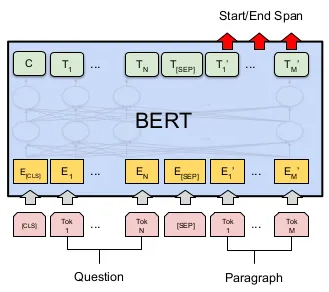

## Подготовка данных под QuestionAnswering

В качестве модели я выбрал sbert_large_nlu_ru, потому что она подходит для русских текстов и nlu модели они универсальны, то есть их можно использовать как для QuestionAnswering, NER, classification и т.д

In [6]:
from transformers import BertForQuestionAnswering
from transformers import BertTokenizerFast
from transformers import BertConfig

# подгружаем токинезатор
tokenizer = BertTokenizerFast(vocab_file = "/content/sbert_large_nlu_ru/vocab.txt",do_lower_case=False)

Первым делом я перевел данный в формат с которым мне будет удобнее работать, то есть это список словарей.

In [ ]:
# Выделим данные на train, test, val
Train_data, buf_data = train_test_split(train_df,test_size=0.2,shuffle=True,stratify=train_df['label'],random_state=1234)
Test_data, Val_data = train_test_split(buf_data,test_size=0.5,shuffle=True,stratify=buf_data['label'],random_state=1234)

Train_data = Train_data.reset_index()
Test_data = Test_data.reset_index()
Val_data = Val_data.reset_index()

# data_train - структура данных, которая представляет собой список словарей, а словарь который содержит текст, лэйбл, начало и конец выделенной части
data_train = []
for i in range(len(Train_data)):
    data = {}
    data['text'] = Train_data['text'][i]
    data['entities'] = []
    lab = Train_data['label'][i]
    st = Train_data['extracted_part'][i]['answer_start'][0]
    en = Train_data['extracted_part'][i]['answer_end'][0]

    data['entities'].append({"label":lab, "start":st,"end":en})
    data_train.append(data)

data_test = []
for i in range(len(Test_data)):
    data = {}
    data['text'] = Test_data['text'][i]
    data['entities'] = []
    lab = Test_data['label'][i]
    st = Test_data['extracted_part'][i]['answer_start'][0]
    en = Test_data['extracted_part'][i]['answer_end'][0]

    data['entities'].append({"label":lab, "start":st,"end":en})
    data_test.append(data)

data_val = []
for i in range(len(Val_data)):
    data = {}
    data['text'] = Val_data['text'][i]
    data['entities'] = []
    lab = Val_data['label'][i]
    st = Val_data['extracted_part'][i]['answer_start'][0]
    en = Val_data['extracted_part'][i]['answer_end'][0]

    data['entities'].append({"label":lab, "start":st,"end":en})
    data_val.append(data)

Пример данных

In [ ]:
data_train[0]

{'text': 'Извещение о проведении запроса котировок в электронной форме для закупки №0142300011622000057 Общая информация Номер извещения 0142300011622000057 Наименование объекта закупки поставка масел моторных Способ определения поставщика (подрядчика, исполнителя) Запрос котировок в бл, Чапаевск г, улица Сазонова 7А Предусмотрена возможность одностороннего отказа от исполнения контракта в соответствии со ст. 95 Закона № 44-ФЗ Да Обеспечение заявки Обеспечение заявок не требуется Обеспечение исполнения контракта Требуется обеспечение исполнения контракта Размер обеспечения исполнения контракта 10.00% Порядок обеспечения исполнения контракта, требования к обеспечению В соответствии с проектом контракта Платежные реквизиты "Номер расчётного счёта" 00000000000000000000 "Номер лицевого счёта" См. прилагаемые документы "БИК" 000000000 "Наименование кредитной организации" "Номер корреспондентского счета" Требования к гарантии качества товара, работы, услуги Требуется гарантия качества товара

###tokenize_sen

Токенизируем текст. Функция возвращает encoding, start_token, end_token, label

In [ ]:
def tokenize_sen(json_data,t = "Train"):
    text = json_data['text']
    encoding = tokenizer(text,add_special_tokens=False)[0]

    if t == "Train":
        # Извекаем начало, конец и лэйбл
        start_sen = json_data['entities'][0]['start']
        end_sen = json_data['entities'][0]['end']
        label = json_data['entities'][0]['label']
        if end_sen==0:
            return encoding, 0, 0, label
        else:
            # Извлекаем номера токенов, которые соответствует start_sen и end_sen-1
            start_token = encoding.char_to_token(start_sen)
            end_token = encoding.char_to_token(end_sen-1)

            if start_token!=None and end_token!=None:
                return encoding, start_token, end_token, label
            else:
                return None,None, None,None
    elif t == "Test":
        # На тесте извлекать start и end не нужно
        label = json_data['entities'][0]['label']
        return encoding, label

### tokenize_sens

Токенизируем все тексты и формируем список словарей, который включает в себя encoding, start_token, end_token, label

In [ ]:
def tokenize_sens(json_datas,t = "Train"):
    enc_st_et = []
    if t == "Train":
        for json_data in tqdm(json_datas):
            d = {}
            # Токенизируем текст и получем его encoding, start, end и label
            e, st, et, lab = tokenize_sen(json_data,t)
            if st!=None and e!=None and et!=None:
                d["encoding"] = e
                d["start_token"] = st
                d["end_token"] = et
                d["label"] = lab
                enc_st_et.append(d)
            
                
    elif t == "Test":
        for json_data in tqdm(json_datas):
            d = {}
            e,lab = tokenize_sen(json_data,t)
            d["encoding"] = e
            d["label"] = lab
            enc_st_et.append(d)
        
    return enc_st_et

In [ ]:
# enc_st_et = tokenize_sens(data_train)

In [ ]:
# enc1 = tokenizer("обеспечение исполнения контракта",add_special_tokens=False)[0]
# enc2 = tokenizer("обеспечение гарантийных обязательств",add_special_tokens=False)[0]

In [ ]:
# enc2.ids

### cut_long_sequence

Формируем данные под bert QuestionAnswering. Длину текста обрезаем так, чтобы его длина была меньше чем 510-len_query, 510 потому что 1 токен на cls, 1 токен на sep. Последовательности обрезать можно, потому что даже если текст длинный, то есть больше 510-len_query, начало и конец ответа находятся где-то около середины, а не в конце. Данные под qa модели состоят из cls + questions_tokens + sep + inputs_ids + pad. Также мы сдвигаем start и end на длину (cls + questions_tokens + sep), потому что мы хотим предсказывать ответ относительно всей входной последовательности, а эта последовательность содержит не только текст, но еще и вопрос в начале. Также фомируем attention_mask и segment_ids

In [ ]:
# Инициализируем индексы cls, pad и sep
CLS_ID = tokenizer.cls_token_id
PAD_ID = tokenizer.pad_token_id
SEP_ID  = tokenizer.sep_token_id

def cut_long_sequence(data_dict,t = "Train"):
    # Токенизируем запрос
    enc = tokenizer(data_dict['label'],add_special_tokens=False)[0]
    len_query = len(enc.ids)
    # Формируем структуру данных под Train, Test
    if t == "Train":
        sequences = {
            "input_ids":[],
            "attention_mask":[],
            "start_token":[0],
            "end_token":[0],
            "segment_ids":[],
            "shift":[]
        }
    elif t == "Test":
        sequences = {
            "input_ids":[],
            "attention_mask":[],
            "segment_ids":[],
            "shift":[]
        }
    
    # Получаем ids и attention_mask
    input_ids = data_dict['encoding'].ids
    att_ids = data_dict['encoding'].attention_mask
    # Если len(input_ids)>=510-len_query, то обрезаем наши айди текста и attention_mask к нему
    if len(input_ids)<510-len_query:
        pass
    else:
        input_ids = input_ids[0:(510-len_query)]
        att_ids = att_ids[0:(510-len_query)]
    
    # Длина padding
    pad_len = 510 - len(input_ids) - len_query

    # Формируем segment_ids, 0 - вопрос, 1 - текст
    num_seg_a = len([CLS_ID]+enc.ids+[SEP_ID])
    num_seg_b = len(input_ids + [PAD_ID] * pad_len)
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # Формируем input_ids и attention_mask нужной длины
    input_ids = [CLS_ID]+enc.ids+[SEP_ID]+input_ids + [PAD_ID] * pad_len
    attention_mask = [1] +enc.attention_mask+[1]+att_ids +[PAD_ID] * pad_len

    #Инициализируем структуру данных
    sequences['input_ids'] = input_ids
    sequences['attention_mask'] = attention_mask
    sequences['segment_ids'] = segment_ids

    if t == "Train":
        sequences['start_token'] = [data_dict['start_token']+len([CLS_ID]+enc.ids+[SEP_ID])]
        sequences['end_token'] = [data_dict['end_token']+len([CLS_ID]+enc.ids+[SEP_ID])]
    sequences['shift'] = [len([CLS_ID]+enc.ids+[SEP_ID])]
    return sequences, data_dict['encoding']

###preprosses

Объединяем предыдущие функции в одну и получаем функцию, которая подготавливает данные

In [ ]:
def preprosses(data,tp = "Train"):
    encodings = []
    if tp == "Train":
        sequences = {
            "input_ids":[],
            "attention_mask":[],
            "start_token":[],
            "end_token":[],
            "segment_ids":[],
            "shift":[]
        }
        cols = ["input_ids", "attention_mask", "start_token", "end_token", "segment_ids","shift"]
    elif tp == "Test":
        sequences = {
            "input_ids":[],
            "attention_mask":[],
            "segment_ids":[],
            "shift":[]
        }
        cols = ["input_ids", "attention_mask", "segment_ids","shift"]

    # Токенизируем данные
    enc_st_et = tokenize_sens(data,tp)

    for i in tqdm(range(len(enc_st_et))):
        # Формируем данные под QA модель, обрезаем длинные последовательности
        sequence,enc = cut_long_sequence(enc_st_et[i],tp)
        encodings.append(enc)
        for t in cols:
            sequences[t].append(sequence[t])
    
    for t in cols:
        sequences[t] = np.array(sequences[t])
    return sequences,encodings

In [ ]:
sequences,encodings_train = preprosses(data_train,tp="Train")
sequences_val,encodings_val = preprosses(data_val,tp="Train")
sequences_test,encodings_test = preprosses(data_test,tp="Train")

100%|██████████| 179/179 [00:00<00:00, 9871.16it/s]


In [ ]:
print(len(sequences['input_ids']))
print(len(sequences['attention_mask']))
print(len(sequences['start_token']))
print(len(sequences['end_token']))
print(len(sequences['segment_ids']))
print(len(sequences['shift']))

1433
1433
1433
1433
1433
1433


In [ ]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self,data_input, data_att, start_token, end_token, segment_ids,shift):
        self.data_input = data_input
        self.data_att = data_att
        self.start_token = start_token
        self.end_token = end_token
        self.segment_ids = segment_ids
        self.shift = shift

    def __len__(self):
        return len(self.data_input)
    
    def __getitem__(self,idx):
        return torch.from_numpy(self.data_input[idx]),torch.from_numpy(self.data_att[idx]),torch.from_numpy(self.segment_ids[idx]),torch.from_numpy(self.start_token[idx]),torch.from_numpy(self.end_token[idx]), torch.from_numpy(self.shift[idx])

Берем структуру данных, которую мы сформировали и извлекаем из них данные начала, конца и т.д и добавляем их в список, чтобы потом сформировать Dataset

In [ ]:
def form_data(seq):
    start_tokens_buf = []
    end_tokens_buf = []
    segment_ids_buf = []
    attention_mask_buf = []
    input_ids_buf = []
    shifts = []
    for i in range(len(seq['input_ids'])):
        attention_mask_buf.append(seq['attention_mask'][i])
        input_ids_buf.append(seq['input_ids'][i])
        segment_ids_buf.append(seq['segment_ids'][i])
        start_tokens_buf.append(seq['start_token'][i])
        end_tokens_buf.append(seq['end_token'][i])
        shifts.append(seq['shift'][i])
    
    segment_ids_buf = np.array(segment_ids_buf)
    attention_mask_buf = np.array(attention_mask_buf)
    input_ids_buf = np.array(input_ids_buf)
    start_tokens_buf = np.array(start_tokens_buf)
    end_tokens_buf = np.array(end_tokens_buf)
    shifts = np.array(shifts)
    
    return input_ids_buf, attention_mask_buf, segment_ids_buf, start_tokens_buf, end_tokens_buf,shifts

In [ ]:
train_input_ids,train_attention_mask,train_segment_ids,train_start_tokens,train_end_tokens,train_shift = form_data(sequences)
val_input_ids,val_attention_mask,val_segment_ids,val_start_tokens,val_end_tokens,val_shift = form_data(sequences_val)
test_input_ids,test_attention_mask,test_segment_ids,test_start_tokens,test_end_tokens,test_shift = form_data(sequences_test)

Проверяем чтобы длины совпадали

In [ ]:
print(len(train_segment_ids))
print(len(train_attention_mask))
print(len(train_input_ids))
print(len(train_start_tokens))
print(len(train_end_tokens))
print(len(train_shift))
print()
print(len(val_segment_ids))
print(len(val_attention_mask))
print(len(val_input_ids))
print(len(val_start_tokens))
print(len(val_end_tokens))
print(len(val_shift))
print()
print(len(test_segment_ids))
print(len(test_attention_mask))
print(len(test_input_ids))
print(len(test_start_tokens))
print(len(test_end_tokens))
print(len(test_shift))

1433
1433
1433
1433
1433
1433

180
180
180
180
180
180

179
179
179
179
179
179


### Dataset, Dataloader

In [ ]:
train_dataset = TrainDataset(train_input_ids, train_attention_mask, train_start_tokens, train_end_tokens, train_segment_ids,train_shift)
val_dataset = TrainDataset(val_input_ids, val_attention_mask, val_start_tokens, val_end_tokens, val_segment_ids,val_shift)
test_dataset = TrainDataset(test_input_ids, test_attention_mask, test_start_tokens, test_end_tokens, test_segment_ids,test_shift)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=False,batch_size=4,num_workers=2,pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=False,batch_size=4,num_workers=2,pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,shuffle=False,batch_size=4,num_workers=2,pin_memory=True)

##Тренировка модели

In [7]:
# Чистим кэш
torch.cuda.empty_cache()
import gc
gc.collect()

50

In [10]:
# Задаем модель
config = BertConfig.from_pretrained('/content/sbert_large_nlu_ru/config.json')
model = BertForQuestionAnswering.from_pretrained('/content/sbert_large_nlu_ru/pytorch_model.bin',config = config)
model = model.to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at /content/sbert_large_nlu_ru/pytorch_model.bin and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train

Функция обученния

In [ ]:
def train_qa_bert(model, train_dataloader, val_dataloader,optimizer, epochs = 5, model_name = "Bert_QA"):
    max_grad_norm = 1.0
    best_val_loss = 10000
    best_val_acc = -1
    val_losses = []
    train_losses = []
    val_accs = []
    for epoch in range(epochs):
        train_loss=0
        model.train() # переводим модель в режим обучения
        for batch_inputs, batch_att, batch_segment,batch_start,batch_end,batch_shift in tqdm(train_dataloader):

            batch_inputs = batch_inputs.to(device) # переводим на cudu
            batch_att = batch_att.to(device)
            batch_segment = batch_segment.to(device)
            batch_start = batch_start.to(device)
            batch_end = batch_end.to(device)

            optimizer.zero_grad() #устанавливаем градиенты на ноль, так как PyTorch их накапливает

            outputs = model(
                input_ids = batch_inputs, attention_mask = batch_att,
                start_positions=batch_start, end_positions=batch_end,
                token_type_ids = batch_segment
                )
        
            loss = outputs.loss # извлекаем loss
            loss.backward() # вычисляем градиенты
            train_loss+=loss.item()

            clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            optimizer.step() # делаем шаг


        predicted_start = []
        predicted_end = []
        true_start = []
        true_end = []


        model.eval()#переводим сеть в состояние тестирования
        eval_loss=0
        m = 0
        with torch.no_grad():#не вычисляем параметры
            for batch_inputs, batch_att, batch_segment,batch_start,batch_end,batch_shift in tqdm(val_dataloader):

                batch_inputs = batch_inputs.to(device) # переводим на cudu
                batch_att = batch_att.to(device)
                batch_segment = batch_segment.to(device)
                batch_start = batch_start.to(device)
                batch_end = batch_end.to(device)

                outputs = model(
                    input_ids = batch_inputs, attention_mask = batch_att,
                    start_positions=batch_start, end_positions=batch_end,
                    token_type_ids = batch_segment
                    )
                
                eval_loss += outputs.loss.item()

                # Извлекаем индекс начала и конца и добавляем их в список
                predicted_start.extend(torch.argmax(outputs.start_logits,axis=-1).detach().cpu().numpy())
                predicted_end.extend(torch.argmax(outputs.end_logits,axis=-1).detach().cpu().numpy())

                true_start.extend(batch_start.detach().cpu().numpy())
                true_end.extend(batch_end.detach().cpu().numpy())

            #Считаем точность
            for i in range(len(predicted_start)):
                if predicted_start[i]==true_start[i][0] and predicted_end[i]==true_end[i][0]:
                    m+=1
            val_acc = m/len(predicted_start)
            eval_loss = eval_loss/len(val_dataloader)

        print(f"Epoch = {epoch}")
        print(f"Loss на обучающей выборке = {train_loss / len(train_dataloader)}")
        print(f"Loss на валидационной выборке = {eval_loss}")
        print(f"Acc на валидационной выборке = {val_acc}")

        train_losses.append(train_loss / len(train_dataloader))
        val_losses.append(eval_loss)
        val_accs.append(val_acc)
        """
        Сохраняем модель, у которой самая высокая точность на val
        """
        if val_acc > best_val_acc:
            print(f'Save best model with val acc {val_acc}')
            state = {
                'model': model.state_dict(),
                'optimizer' : optimizer.state_dict()}
            torch.save(state,f"/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/Models/{model_name}.pt")
            best_val_acc = val_acc
        else:
            print(f"Don't save model with val error {val_acc}")
        print()
    return model, train_losses, val_losses, val_accs

In [ ]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=5e-5)

In [ ]:
final_model, train_losses, val_losses,val_acc = train_qa_bert(model, train_dataloader, val_dataloader,optimizer, epochs = 5, model_name = "Bert_QA_1")

Text(0, 0.5, 'acc')

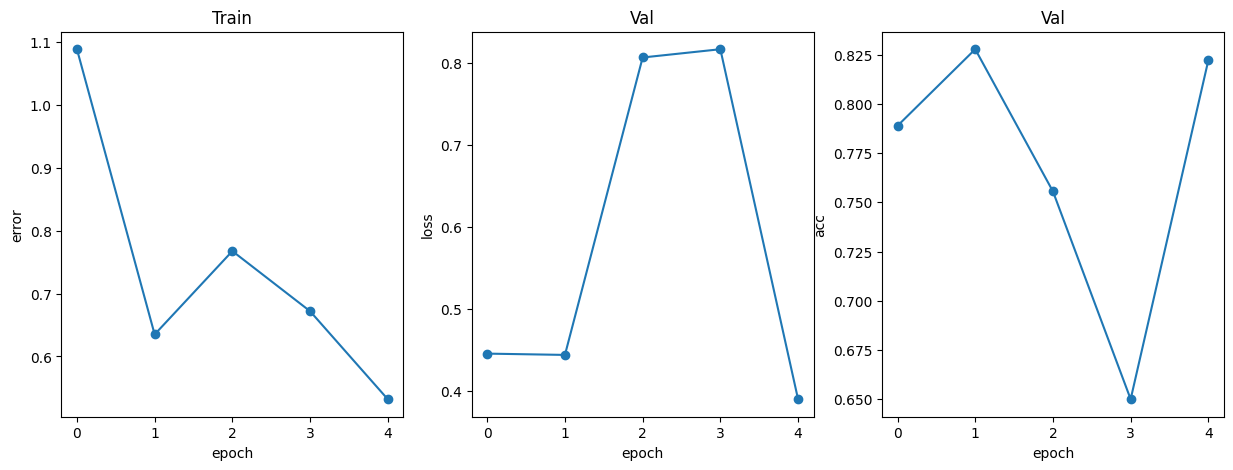

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(train_losses,marker='o')
plt.title("Train")
plt.xlabel("epoch")
plt.ylabel("error")

plt.subplot(1,3,2)
plt.plot(val_losses,marker='o')
plt.title("Val")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1,3,3)
plt.plot(val_acc,marker='o')
plt.title("Val")
plt.xlabel("epoch")
plt.ylabel("acc")

### Результаты на test

In [ ]:
# Чистим кэш
torch.cuda.empty_cache()
import gc
gc.collect()

0

Подгружаем лучшую модель

In [ ]:
from transformers import BertConfig,BertForQuestionAnswering

config = BertConfig.from_pretrained('/content/sbert_large_nlu_ru/config.json')

state=torch.load("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/Models/Bert_QA_1.pt")
model = BertForQuestionAnswering.from_pretrained(pretrained_model_name_or_path=None, state_dict=state['model'], config=config)
model = model.to(device)

In [ ]:
model.eval()#переводим сеть в состояние тестирования
eval_loss=0
predicted_start = []
predicted_end = []
shifts = []

true_start = []
true_end = []

with torch.no_grad():#не вычисляем параметры
    for batch_inputs, batch_att, batch_segment,batch_start,batch_end, shift in tqdm(test_dataloader):

        batch_inputs = batch_inputs.to(device) # переводим на cudu
        batch_att = batch_att.to(device)
        batch_segment = batch_segment.to(device)
        batch_start = batch_start.to(device)
        batch_end = batch_end.to(device)

        outputs = model(
            input_ids = batch_inputs, attention_mask = batch_att,
            start_positions=batch_start, end_positions=batch_end,
            token_type_ids = batch_segment
            )
        
        # Извлекаем начало, конец и сдвиг и добавляем их в списки
        predicted_start.extend(torch.argmax(outputs.start_logits,axis=-1).detach().cpu().numpy())
        predicted_end.extend(torch.argmax(outputs.end_logits,axis=-1).detach().cpu().numpy())
        shifts.extend(shift.numpy())

        true_start.extend(batch_start.detach().cpu().numpy())
        true_end.extend(batch_end.detach().cpu().numpy())

100%|██████████| 45/45 [00:23<00:00,  1.95it/s]


В предыдущей ячейке мы извлекли начало и конец относительно токенов. Переведем их в индексы отноистельно текста

In [ ]:
predicted_start_r = []
predicted_end_r = []

true_start_r = []
true_end_r = []
for i in range(len(predicted_end)):

    # len(data_test) больше len(predicted_end) на единицу, потому что одна запись была невалидная,
    # поэтому после 39 будем брать data_test[i+1]
    if i >= 39:
        start = data_test[i+1]['entities'][0]['start']
        end = data_test[i+1]['entities'][0]['end']
    else:
        start = data_test[i]['entities'][0]['start']
        end = data_test[i]['entities'][0]['end']

    true_start_r.append(start)
    true_end_r.append(end)

    # Если predicted_start[i] - shifts[i][0] <=0, говорим что в соответствии с этим запросом информация не выделена
    # и возвращаем 0,0
    if predicted_start[i] - shifts[i][0]<=0 or predicted_end[i]-shifts[i][0]<=0:
        predicted_start_r.append(0)
        predicted_end_r.append(0)
    else:       
        if encodings_test[i].token_to_chars(predicted_start[i] - shifts[i][0]) != None and encodings_test[i].token_to_chars(predicted_end[i]-shifts[i][0])!= None:
            # predicted_end[i] - shifts[i][0] == 0 говорим что в соответствии с этим запросом информация не выделена,
            # и возвращаем 0,0
            if predicted_end[i] - shifts[i][0] == 0:
                predicted_start_r.append(0)
                predicted_end_r.append(0)
            else: 
                start,_ = encodings_test[i].token_to_chars(predicted_start[i] - shifts[i][0])# Получаю индекс в строке в соответствии с токеном
                _,end = encodings_test[i].token_to_chars(predicted_end[i] - shifts[i][0])
                predicted_start_r.append(start)
                predicted_end_r.append(end)
        else:
            predicted_start_r.append(0)
            predicted_end_r.append(0)


In [ ]:
for i in range(len(predicted_start_r)):
    if predicted_start_r[i]>=predicted_end_r[i]:
        predicted_start_r[i]=0
        predicted_end_r[i]=0

In [ ]:
print(len(predicted_start_r))
print(len(predicted_end_r))
print(len(true_start_r))
print(len(true_end_r))

179
179
179
179


Точность относительно токенов

In [ ]:
m = 0
for i in range(len(predicted_start)):
    if predicted_start[i]==true_start[i][0] and predicted_end[i]==true_end[i][0]:
        m+=1

In [ ]:
m/len(predicted_start)

0.770949720670391

Точность относительно обычного предложения

In [ ]:
m = 0
wrong_indexs = []
right_index = []
for i in range(len(predicted_start_r)):
    if predicted_start_r[i]==true_start_r[i] and predicted_end_r[i]==true_end_r[i]:
        m+=1
        right_index.append(i)
    else:
        wrong_indexs.append(i)

In [ ]:
m/len(predicted_start)

0.770949720670391

Эти две точности должны совпадать

### Исследование неправильно выделенных предложений

In [ ]:
len(wrong_indexs)

41

In [ ]:
for i,wrong_index in enumerate(wrong_indexs):
    if wrong_index >= 39:
        print(f"Predicted text--{data_test[wrong_index+1]['text'][predicted_start_r[wrong_index]:predicted_end_r[wrong_index]]}--{predicted_start_r[wrong_index]},{predicted_end_r[wrong_index]}")
        print(f"True text--{data_test[wrong_index+1]['text'][true_start_r[wrong_index]:true_end_r[wrong_index]]}--{true_start_r[wrong_index]},{true_end_r[wrong_index]}")

    else:
        print(f"Predicted text--{data_test[wrong_index]['text'][predicted_start_r[wrong_index]:predicted_end_r[wrong_index]]}--{predicted_start_r[wrong_index]},{predicted_end_r[wrong_index]}")
        print(f"True text--{data_test[wrong_index]['text'][true_start_r[wrong_index]:true_end_r[wrong_index]]}--{true_start_r[wrong_index]},{true_end_r[wrong_index]}")
        
    print()
    print()

Predicted text--контракт заключается только после предоставления таким участником обеспечения исполнения контракта в размере, превышающем в 1,5 раза размер обеспечения исполнения контракта, указанный в извещении, но не менее чем 10 процентов от начальной (максимальной) цены контракта--1219,1487
True text--таким участником обеспечения исполнения контракта в размере, превышающем в 1,5 раза размер обеспечения исполнения контракта, указанный в извещении, но не менее чем 10 процентов от начальной (максимальной) цены контракта--1268,1487


Predicted text--Размер обеспечения исполнения Контракта 50 % от цены контракта, что составляет ________________________ руб.--1014,1122
True text--Размер обеспечения исполнения Контракта 50 % от цены контракта, что составляет ________________________--1014,1117


Predicted text--Размер обеспечения исполнения контракта устанавливается в размере 5 (пять) процентов от цены, по которой заключается контракт и составляет _________--1256,1404
True text--Размер об

Можно заметить, что в большинстве случаев, на которых модель ошиблась, она правильно определяет начало, но неверно конец: либо выделяет чуть-чуть больше информации или чуть чуть меньше

## Test

In [ ]:
# Чистим кэш
torch.cuda.empty_cache()
import gc
gc.collect()

0

Подгружаем лучшую модель

In [ ]:
from transformers import BertConfig,BertForQuestionAnswering

config = BertConfig.from_pretrained('/content/sbert_large_nlu_ru/config.json')

state=torch.load("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/Models/Bert_QA_1.pt")
model = BertForQuestionAnswering.from_pretrained(pretrained_model_name_or_path=None, state_dict=state['model'], config=config)
model = model.to(device)

In [ ]:
test_df = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/dataset/test.json")

In [ ]:
test_df.head(3)

,id,text,label
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта


Дальше подготавливаем данные в модель. Данные подготавливаются почти точно также

In [ ]:
data_test = []
for i in range(len(test_df)):
    data = {}
    data['text'] = test_df['text'][i]
    data['entities'] = []
    lab = test_df['label'][i]

    data['entities'].append({"label":lab})
    data_test.append(data)

In [ ]:
sequences_test,encodings_test = preprosses(data_test,tp="Test")

100%|██████████| 318/318 [00:00<00:00, 8830.93it/s]


In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self,data_input, data_att, segment_ids,shift):
        self.data_input = data_input
        self.data_att = data_att
        self.segment_ids = segment_ids
        self.shift = shift
    def __len__(self):
        return len(self.data_input)
    
    def __getitem__(self,idx):
        return torch.from_numpy(self.data_input[idx]),torch.from_numpy(self.data_att[idx]),torch.from_numpy(self.segment_ids[idx]),torch.from_numpy(self.shift[idx])

In [ ]:
test_segment_ids = []
test_attention_mask = []
test_input_ids = []
test_shift = []
for i in range(len(sequences_test['input_ids'])):
    test_attention_mask.append(sequences_test['attention_mask'][i])
    test_input_ids.append(sequences_test['input_ids'][i])
    test_segment_ids.append(sequences_test['segment_ids'][i])
    test_shift.append(sequences_test['shift'][i])

print(len(test_segment_ids))
print(len(test_attention_mask))
print(len(test_input_ids))
print(len(test_shift))

318
318
318
318


In [ ]:
test_segment_ids = np.array(test_segment_ids)
test_attention_mask = np.array(test_attention_mask)
test_input_ids = np.array(test_input_ids)
test_shift = np.array(test_shift)


In [ ]:
test_dataset = TestDataset(test_input_ids, test_attention_mask, test_segment_ids,test_shift)
test_dataloader = torch.utils.data.DataLoader(test_dataset,shuffle=False,batch_size=4,num_workers=2,pin_memory=True)

Предсказываем

In [ ]:
model.eval()#переводим сеть в состояние тестирования
eval_loss=0
predicted_start = []
predicted_end = []
shifts = []

with torch.no_grad():#не вычисляем параметры
    for batch_inputs, batch_att, batch_segment, shift in tqdm(test_dataloader):

        batch_inputs = batch_inputs.to(device) # переводим на cudu
        batch_att = batch_att.to(device)
        batch_segment = batch_segment.to(device)

        outputs = model(
            input_ids = batch_inputs, attention_mask = batch_att,
            token_type_ids = batch_segment
            )
        
        predicted_start.extend(torch.argmax(outputs.start_logits,axis=-1).detach().cpu().numpy())
        predicted_end.extend(torch.argmax(outputs.end_logits,axis=-1).detach().cpu().numpy())
        shifts.extend(shift.numpy())


100%|██████████| 80/80 [00:34<00:00,  2.29it/s]


In [ ]:
print(len(shifts))
print(len(predicted_end))
print(len(predicted_start))

318
318
318


С ответов на токенах переходим в ответы на текстах

In [ ]:
predicted_start_r = []
predicted_end_r = []

for i in range(len(predicted_end)):

    if predicted_start[i] - shifts[i][0] < 0 or predicted_end[i]-shifts[i][0] < 0:
        predicted_start_r.append(0)
        predicted_end_r.append(0)
    else:
        if encodings_test[i].token_to_chars(predicted_start[i] - shifts[i][0]) != None and encodings_test[i].token_to_chars(predicted_end[i]-shifts[i][0])!= None:
            if predicted_end[i] - shifts[i][0] == 0:
                predicted_start_r.append(0)
                predicted_end_r.append(0)
            else: 
                start,_ = encodings_test[i].token_to_chars(predicted_start[i] - shifts[i][0])
                _,end = encodings_test[i].token_to_chars(predicted_end[i] - shifts[i][0])
                predicted_start_r.append(start)
                predicted_end_r.append(end)
        else:
            predicted_start_r.append(0)
            predicted_end_r.append(0)


In [ ]:
for i in range(len(predicted_start_r)):
    if predicted_start_r[i]>=predicted_end_r[i]:
        predicted_start_r[i]=0
        predicted_end_r[i]=0

In [ ]:
print(len(predicted_start_r))
print(len(predicted_end_r))

318
318


### Формирование данных под результат

In [ ]:
test_df["answer_start"] = 0
test_df["answer_end"] = 0
test_df["answer_text"] = 0

In [ ]:
# Заполняем таблица answer_start, answer_end, answer_text
for i in range(len(predicted_start_r)):
    test_df['answer_start'][i]=predicted_start_r[i]
    test_df['answer_end'][i]=predicted_end_r[i]
    test_df['answer_text'][i]=data_test[i]['text'][predicted_start_r[i]:predicted_end_r[i]]

In [ ]:
test_df

,id,text,label,answer_start,answer_end,answer_text
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,1283,1393,Размер обеспечения исполнения Контракта состав...
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,1291,1337,Размер обеспечения исполнения контракта 10.00%
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,1300,1412,Размер обеспечение исполнения контракта устана...
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта,1312,1424,Размер обеспечение исполнения контракта устана...
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта,1314,1426,Размер обеспечение исполнения контракта устана...
...,...,...,...,...,...,...
313,854936033,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,обеспечение гарантийных обязательств,0,0,
314,576390745,Часть III Проект договора Договор №______ пост...,обеспечение гарантийных обязательств,1301,1425,Размер обеспечения гарантийных обязательств не...
315,323745820,УТВЕРЖДАЮ Председатель единой комиссии по осущ...,обеспечение гарантийных обязательств,0,0,
316,712286194,Версия с 04.07.2022 года У Т В Е Р Ж Д А Ю «Го...,обеспечение гарантийных обязательств,1220,1272,Обеспечение гарантийных обязательств: Не устан...


Формируем список словарей со всеми нужными данными

In [ ]:
final_json = []
for i in range(len(test_df)):
    f_data = {}
    f_data["id"] = test_df['id'][i]
    f_data["text"]  = test_df['text'][i]
    f_data["label"] = test_df['label'][i]
    f_data["extracted_part"] = {
        'text':[test_df['answer_text'][i]],
        'answer_start':[test_df['answer_start'][i]],
        'answer_end':[test_df['answer_end'][i]]
    }
    final_json.append(f_data)

In [ ]:
len(final_json)

318

In [ ]:
test_df = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/dataset/test.json")

Формируем колонку extracted_part

In [ ]:
test_df["extracted_part"] = 0

In [ ]:
for i in range(len(final_json)):
    if final_json[i]["extracted_part"]['answer_start'][0]==0 and final_json[i]["extracted_part"]['answer_end'][0]==0:
        final_json[i]["extracted_part"]['text'] = [""]
        test_df["extracted_part"][i] = final_json[i]["extracted_part"]
    else:
        test_df["extracted_part"][i] = final_json[i]["extracted_part"]

In [ ]:
test_df

,id,text,label,extracted_part
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения Контр...
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...
...,...,...,...,...
313,854936033,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_en..."
314,576390745,Часть III Проект договора Договор №______ пост...,обеспечение гарантийных обязательств,{'text': ['Размер обеспечения гарантийных обяз...
315,323745820,УТВЕРЖДАЮ Председатель единой комиссии по осущ...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_en..."
316,712286194,Версия с 04.07.2022 года У Т В Е Р Ж Д А Ю «Го...,обеспечение гарантийных обязательств,{'text': ['Обеспечение гарантийных обязательст...


Сохраняем

In [ ]:
with open('/content/predictions.json', 'w', encoding='utf-8') as file:
    test_df.to_json(file,orient = "records", force_ascii=False)


#NER задача

In [ ]:
!pip install transformers
!pip install Keras-Preprocessing

!git lfs install
!git clone https://huggingface.co/ai-forever/sbert_large_nlu_ru

In [ ]:
train_df = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/dataset/train.json")

In [ ]:
device = 'cuda'

## Подготовка данных под NER

Данную задачу я свел к NER задачи

Идея: на вход модели подается текст, а она выделяет сущности, которые представляют собой лэйблы

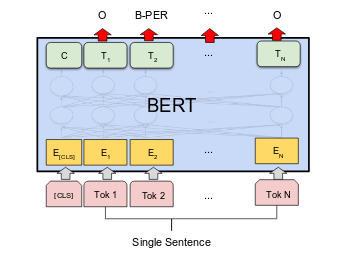

In [ ]:
from transformers import BertTokenizerFast
#подгружаем токинезатор
tokenizer = BertTokenizerFast(vocab_file = "/content/sbert_large_nlu_ru/vocab.txt",do_lower_case=False)

In [ ]:
# Выделение индексов тех текстов, к которым по запросу не нашелся ответ.
# Такие тексты я исключу из обучаэщей выборки, потому что главная цель моего NER это находить в тексте сущности 
# "обеспечение исполнения контракта" или "обеспечение гарантийных обязательств", а если я их не исключу, и мы 
# сделаем запрос "обеспечение исполнения контракта" и он ничего не нашел, а на самом деле там есть "обеспечение гарантийных обязательств",
# то это запутает модель
indexes_without_blank = []
indexes_with_blank = []
for i in range(len(train_df)):
    if train_df['extracted_part'][i]['answer_end'][0]!=0:
        indexes_without_blank.append(True)
        indexes_with_blank.append(False)
    else:
        indexes_without_blank.append(False)
        indexes_with_blank.append(True)

# заменим "обеспечение исполнения контракта" на "EXE"
# заменим "обеспечение гарантийных обязательств" на "GUA"
# эти лэйблы будут использоваться в формате BIO
normal_labels = []
for i in range(len(train_df)):
    if train_df['label'][i] == "обеспечение исполнения контракта":
        normal_labels.append("EXE")
    elif train_df['label'][i] == "обеспечение гарантийных обязательств":
        normal_labels.append("GUA")

train_df['normal_labels'] = normal_labels

df_empty_text = train_df[indexes_with_blank]
train_df = train_df[indexes_without_blank]

train_df = train_df.reset_index()
df_empty_text = df_empty_text.reset_index()


# Выделим данные на train, test, val
Train_data, buf_data = train_test_split(train_df,test_size=0.2,shuffle=True,stratify=train_df['label'],random_state=1234)
Test_data, Val_data = train_test_split(buf_data,test_size=0.5,shuffle=True,stratify=buf_data['label'],random_state=1234)

Train_data = Train_data.reset_index()
Test_data = Test_data.reset_index()
Val_data = Val_data.reset_index()

# data_train - структура данных, которая которая представляет собой список словарей, а словарь который содержит текст, лэйбл, начало и конец выделенной части
data_train = []
for i in range(len(Train_data)):
    data = {}
    data['text'] = Train_data['text'][i]
    data['entities'] = []
    lab = Train_data['normal_labels'][i]
    st = Train_data['extracted_part'][i]['answer_start'][0]
    en = Train_data['extracted_part'][i]['answer_end'][0]

    data['entities'].append({"label":lab, "start":st,"end":en})
    data_train.append(data)


data_val = []
for i in range(len(Val_data)):
    data = {}
    data['text'] = Val_data['text'][i]
    data['entities'] = []
    lab = Val_data['normal_labels'][i]
    st = Val_data['extracted_part'][i]['answer_start'][0]
    en = Val_data['extracted_part'][i]['answer_end'][0]

    data['entities'].append({"label":lab, "start":st,"end":en})
    data_val.append(data)

data_test_without_blank = []
for i in range(len(Test_data)):
    data = {}
    data['text'] = Test_data['text'].iloc[i]
    data['entities'] = []
    lab = Test_data['normal_labels'].iloc[i]
    st = Test_data['extracted_part'].iloc[i]['answer_start'][0]
    en = Test_data['extracted_part'].iloc[i]['answer_end'][0]

    data['entities'].append({"label":lab, "start":st,"end":en})
    data_test_without_blank.append(data)

# К тестовым данным добавим еще те данные, где start = 0 и end = 0
Test_data.drop(['level_0'],axis=1,inplace=True)
Test_data = pd.concat([Test_data,df_empty_text])

data_test = []
for i in range(len(Test_data)):
    data = {}
    data['text'] = Test_data['text'].iloc[i]
    data['entities'] = []
    lab = Test_data['normal_labels'].iloc[i]
    st = Test_data['extracted_part'].iloc[i]['answer_start'][0]
    en = Test_data['extracted_part'].iloc[i]['answer_end'][0]

    data['entities'].append({"label":lab, "start":st,"end":en})
    data_test.append(data)

In [ ]:
print(len(data_val))
print(len(data_test))
print(len(data_train))
print(len(data_test_without_blank))

150
456
1193
149


Пример data_train

In [ ]:
data_train[0]

{'text': 'Извещение о проведении электронного аукциона для закупки №0859200001122010551 Общая информация Номер извещения 0859200001122010551 Наименование объекта закупки Поставка бытовой техники Способ определения поставщика (подрядчика, исполнителя) Электронный аукцион Наименование электронной площадки в НКА РОССИИ//УФК по Рязанской области "Номер корреспондентского счета" 40102810345370000051 Требования к гарантии качества товара, работы, услуги Требуется гарантия качества товара, работы, услуги Да Информация о требованиях к гарантийному обслуживанию товара Гарантийное обслуживание оборудования - на месте эксплуатации Товара или в сервисном центре - при наличии в городе. Доставка неисправного Товара для выполнения гарантийного ремонта и обратно Заказчику - после проведения ремонта осуществляется Поставщиком за его счет. Требования к гарантии производителя товара Гарантия на поставляемый Товар должна подтверждаться гарантией производителя и гарантией Поставщика, соответствующей по сро

### tokenize_sen

In [ ]:
# Словарь сущностей
label2id = {'[PAD]': 0, 'O': 1, 'B-EXE': 2, 'I-EXE': 3, 'B-GUA': 4, 'I-GUA': 5}
id2label = {0:'[PAD]', 1:'O', 2:'B-EXE', 3:'I-EXE', 4:'B-GUA',5:'I-GUA'}

# label2id = {tokenizer.pad_token: tokenizer.pad_token_id}
# id2label = {tokenizer.pad_token_id: tokenizer.pad_token}
tensor_names = ('input_ids', 'attention_mask', 'labels')
max_len = 511

Токенизируем текст и формируем лэйблы в формате BIO

Функция tokenize_sen вернет labels и encoding

In [ ]:
def tokenize_sen(json_data):
    text = json_data['text']
    # Токенизируем текст
    encoding = tokenizer(text,add_special_tokens=False)[0]

    # Инициализируем label_names с помощью O
    label_names = ['O' for i in range(len(encoding.tokens))]

    # Извлекаем начало, конец, label_name
    start_sen = json_data['entities'][0]['start']
    end_sen = json_data['entities'][0]['end']
    label_name = json_data['entities'][0]['label']

    # Если начало = 0, конец = 0, то label_names состоит только из 'O'.
    # label_names переводим в ids
    if start_sen == 0 and end_sen == 0:
        labels = []
        for label_name in label_names:
            if label_name not in label2id:
                label2id[label_name] = len(label2id)
                id2label[label2id[label_name]] = label_name
            labels.append(label2id[label_name])
        return labels, encoding
    else:
        # Извлекаем номера токенов которые соответствуют start_sen, end_sen-1
        start_token = encoding.char_to_token(start_sen)
        end_token = encoding.char_to_token(end_sen-1)

        # Формируем label_names в соответствии с start_token и end_token.
        # То есть в в позиции start_token располагаем "B-{label_name}", а во всех остальных до end_token располагаем "I-{label_name}"
        if start_token!=None and end_token!=None:
            for i in range(start_token,end_token+1,1):
                if i == start_token:
                    label_names[i] = f"B-{label_name}"
                else:
                    label_names[i] = f"I-{label_name}"

            labels = []
            # label_names переводим в ids
            for label_name in label_names:
                if label_name not in label2id:
                    label2id[label_name] = len(label2id)
                    id2label[label2id[label_name]] = label_name

                labels.append(label2id[label_name])

            return labels, encoding
        else:
            return None,None

Пример выходных данных

In [ ]:
# index = 3
# l,e = tokenize_sen(data_train[index])
# print(data_train[index]['text'][data_train[index]['entities'][0]['start']:data_train[index]['entities'][0]['end']])
# print()
# print(list(np.array(e.tokens)[np.array(l) == 2])+list(np.array(e.tokens)[np.array(l) == 3]))

Устанавливается требование обеспечения исполнения Договора на участие в запросе котировок в размере - 5%- 17 416,70 (семнадцать тысяч четыреста шестнадцать) рублей

['Устанавли', '##вается', 'требование', 'обеспечения', 'исполнения', 'Договора', 'на', 'участие', 'в', 'запросе', 'котировок', 'в', 'размере', '-', '5', '%', '-', '17', '416', ',', '70', '(', 'семнадцать', 'тысяч', 'четыреста', 'шестнадцать', ')', 'рублей']


### tokenize_sens

Токенизируем все тексты и формируем лэйблы в формате BIO. Функция вернет список encodings, labels

In [ ]:
def tokenize_sens(json_datas):
    encodings = []
    labels = []

    for json_data in tqdm(json_datas):
        l,e = tokenize_sen(json_data)
        if l!=None and e!=None:
            labels.append(l)
            encodings.append(e)
        
    return encodings, labels

In [ ]:
# encodings, labels = tokenize_sens(data_train)

100%|██████████| 1193/1193 [00:03<00:00, 375.53it/s]


In [ ]:
# print(len(encodings))
# print(len(labels))
# print(len(data_train))

1186
1186
1193


### add_special_tokens

Подготавление последовательностей под BERT, то есть в начале input_ids добавляем cls token и дополняем до 512 pad токенами, в начале attention_mask добавляем 1 и дополняем до 512 pad токенами, в начале labels добавляем id 'O' и дополняем до 512 pad токенами

In [ ]:
def add_special_tokens(array, type_='input_ids'):
    # Инициализируем индексы cls, pad
    CLS_ID = tokenizer.cls_token_id
    PAD_ID = tokenizer.pad_token_id

    pad_len = max_len - len(array)

    # Добавляем специальные токены в соответствии с типом последовательности.
    # Если тип input_ids, то добавляем CLS_ID в начало, если attention_mask то 1,
    # если labels, то id 'O'
    if type_ == 'input_ids':
        new_array = [CLS_ID] + array + [PAD_ID] * pad_len
    elif type_ == 'attention_mask':
        new_array = [1] + array + [PAD_ID] * pad_len
    elif type_ == 'labels':
        l_id = label2id['O']
        new_array = [l_id] + array + [PAD_ID] * pad_len
 
    return new_array

### cut_long_sequence

Последовательности могут быть больше 512, а BERT работает с последовательностями длины 512, поэтому длинные последовательности нужно разделить. Раздаление происходит либо по точке, вопросительному знаку или восклицательному знаку или если нету этих знаков то по слову ближайшему к разделению, но которое не содержит ##. Если в функцию переданы лэйблы то разбиение не может быть по I. Также эта функция будет иметь две позиции разбиения, одну по ('.', '?', '!'), другую альтернативную, по самому ближайшему к границе разбиению целого токена, то есть нельзя разбить по ##...(так токенизирует WordPiece)

In [ ]:
def cut_long_sequence(encoding, labels=None):

    # Инициализируем симовлы разбиения
    end_symbols = frozenset(('.', '?', '!'))
    split_labels_types = frozenset(('O', 'B'))
    border = max_len
    split_position = None
    split_position_alt = None
    split_positions = [0]

    # Формируем последовательности
    # tensor_names = ('input_ids', 'attention_mask', 'labels')
    sequences = {t: [] for t in tensor_names}
    sequence_len = len(encoding.ids)


    if sequence_len < max_len:
        # Есди длина последовательности меньше max_len, просто добавляем начальный токен и дополняем токены в конце
        s_input_ids = add_special_tokens(encoding.ids, 'input_ids')
        sequences['input_ids'].append(s_input_ids)

        s_attention_mask = add_special_tokens(encoding.attention_mask, 'attention_mask')
        sequences['attention_mask'].append(s_attention_mask)

        if labels is not None:

            s_labels = add_special_tokens(labels, 'labels')
            sequences['labels'].append(s_labels)
        
    else:
        # Длина последовательности больше max_len 
        for i in range(sequence_len):
            if i < border:
                if labels is not None:
                    # Если токен ('.', '?', '!') и лэйбл == 'O', тогда запоминаем позицию разбиения
                    if encoding.tokens[i] in end_symbols and id2label[labels[i]] == 'O':
                        split_position = i + 1

                    if i + 1 < sequence_len:
                        # Если первые два токена не ##(токенизатор WordPiece, поэтому это нормально)
                        # и токен в ('O', 'B'), тогда запоминаем позицию разбиения 
                        if encoding.tokens[i + 1][:2] != '##' and id2label[labels[i + 1]][0] in split_labels_types:
                            split_position_alt = i + 1
                else:
                    # Если labels не переданы, то просто не учитываем labels при поиске разбиений
                    if encoding.tokens[i] in end_symbols:
                        split_position = i + 1

                    if i + 1 < sequence_len:
                        if encoding.tokens[i + 1][:2] != '##':
                            split_position_alt = i + 1
            else:
                # Дабавляем split_position в список split_positions и сдвигаем границу border
                if split_position is not None:
                    split_positions.append(split_position)
                    border = split_position + max_len
                    split_position = None
                else:

                    split_positions.append(split_position_alt)
                    border = split_position_alt + max_len
                    split_position_alt = None

        split_positions.append(sequence_len)

        # Разделяем последовательности в соответствии с split_positions
        for i in range(len(split_positions) - 1):
            s_input_ids = add_special_tokens(
                encoding.ids[split_positions[i]:split_positions[i + 1]],
                'input_ids'
            )
            sequences['input_ids'].append(s_input_ids)

            s_attention_mask = add_special_tokens(
                encoding.attention_mask[split_positions[i]:split_positions[i + 1]],
                'attention_mask'
            )
            sequences['attention_mask'].append(s_attention_mask)

            if labels is not None:

                s_labels = add_special_tokens(
                    labels[split_positions[i]:split_positions[i + 1]],
                    'labels'
                )
                sequences['labels'].append(s_labels)
            
    return sequences


In [ ]:
# index = 1
# l,e = tokenize_sen(data_train[index])
# print(data_train[index]['text'][data_train[index]['entities'][0]['start']:data_train[index]['entities'][0]['end']])
# print()
# print(list(np.array(e.tokens)[np.array(l) == 2])+list(np.array(e.tokens)[np.array(l) == 3]))

Размер обеспечения исполнения контракта 5.00%

['Размер', 'обеспечения', 'исполнения', 'контракта', '5', '.', '00', '%']


In [ ]:
# sequences = cut_long_sequence(e, labels=l)

In [ ]:
# print(len(sequences['input_ids']))
# print(len(sequences['input_ids'][0]))
# print(len(sequences['input_ids'][1]))

2
512
512


In [ ]:
# print(sequences['input_ids'][0])
# print(sequences['input_ids'][1])

[101, 1605, 67174, 104, 12513, 35229, 33012, 849, 29401, 248, 415, 25304, 12626, 15995, 15058, 47470, 102757, 415, 19214, 15964, 5964, 43627, 28171, 1787, 9321, 12131, 102757, 15058, 47470, 102757, 415, 19214, 7782, 87427, 12008, 29401, 117779, 76690, 1186, 19222, 160, 103900, 1829, 61340, 113, 53792, 158, 29774, 15730, 51452, 160, 55841, 121, 36919, 158, 117923, 38127, 7782, 87427, 8974, 15642, 103350, 1277, 2812, 700, 13260, 12107, 113, 5619, 689, 811, 126, 9099, 34260, 248, 6650, 133, 28151, 2009, 54665, 29401, 10581, 14153, 46226, 12008, 29401, 73820, 7782, 87427, 23194, 121, 2218, 121, 9154, 654, 19307, 104934, 420, 121, 76141, 10329, 15106, 4988, 67916, 8824, 23194, 121, 2218, 121, 9154, 7833, 378, 873, 22640, 18118, 160, 7867, 2218, 121, 9154, 158, 21184, 681, 46816, 22640, 14980, 4988, 7782, 87427, 18981, 62723, 18981, 7833, 378, 873, 22640, 18981, 103900, 1829, 61340, 1355, 126, 9474, 126, 1586, 126, 8847, 133, 5028, 47235, 420, 91990, 50397, 9474, 18498, 126, 4835, 25420, 397

### preprosses

Объединяем предыдущие функции в одну и получаем функцию, которая подготавливает данные

In [ ]:
def preprosses(data,data_type = "Train"):
    sequences = {t: [] for t in tensor_names}

    if data_type == "Train":
        encodings, labels = tokenize_sens(data)

    for i in tqdm(range(len(labels))):
        sequence = cut_long_sequence(encodings[i],labels[i])
        for t in tensor_names:
            sequences[t].extend(sequence[t])

    for t in tensor_names:
        sequences[t] = np.array(sequences[t])
    return sequences,encodings

In [ ]:
sequences,encoding_train = preprosses(data_train)
sequences_val,encoding_val = preprosses(data_val)

100%|██████████| 150/150 [00:08<00:00, 17.84it/s]


In [ ]:
print(len(sequences['labels']))
print(len(sequences['attention_mask']))
print(len(sequences['input_ids']))

1658
1658
1658


### Train Dataset

In [ ]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self,data_input, data_att, data_labels):
        self.data_input = data_input
        self.data_att = data_att
        self.data_labels = data_labels

    def __len__(self):
        return len(self.data_input)
    
    def __getitem__(self,idx):
        return torch.from_numpy(self.data_input[idx]),torch.from_numpy(self.data_att[idx]),torch.from_numpy(self.data_labels[idx])

Формируем train_labels, train_attention_mask, train_input_ids

In [ ]:
def form_data(seq):
    labels = []
    attention_mask = []
    input_ids = []
    for i in range(len(seq['labels'])):
        labels.append(seq['labels'][i])
        attention_mask.append(seq['attention_mask'][i])
        input_ids.append(seq['input_ids'][i])

    labels = np.array(labels)
    attention_mask = np.array(attention_mask)
    input_ids = np.array(input_ids)

    return labels, attention_mask, input_ids

In [ ]:
train_labels,train_attention_mask,train_input_ids = form_data(sequences)
val_labels, val_attention_mask, val_input_ids =  form_data(sequences_val)

Проверяем чтобы длины совпадали

In [ ]:
print(len(train_labels))
print(len(train_attention_mask))
print(len(train_input_ids))
print()
print(len(val_labels))
print(len(val_attention_mask))
print(len(val_input_ids))

1658
1658
1658

211
211
211


In [ ]:
train_dataset = TrainDataset(train_input_ids,train_attention_mask, train_labels)
val_dataset = TrainDataset(val_input_ids,val_attention_mask, val_labels)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=False,batch_size=4,num_workers=2,pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=False,batch_size=4,num_workers=2,pin_memory=True)

In [ ]:
label2id

{'[PAD]': 0, 'O': 1, 'B-EXE': 2, 'I-EXE': 3, 'B-GUA': 4, 'I-GUA': 5}

## Тренировка модели

Функция тренировки модели

### Train

In [ ]:
def train_ner_bert(model, train_dataloader, val_dataloader,optimizer, epochs = 5, model_name = "Bert_NER"):
    max_grad_norm = 1.0
    best_val_loss = 10000
    val_losses = []
    train_losses = []
    for epoch in range(epochs):
        train_loss=0
        model.train() # переводим модель в режим обучения
        for batch_inputs, batch_att, batch_labels in tqdm(train_dataloader):

            batch_inputs = batch_inputs.to(device) # переводим на cudu
            batch_att = batch_att.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad() #устанавливаем градиенты на ноль, так как PyTorch их накапливает

            outputs = model(batch_inputs, attention_mask=batch_att,labels=batch_labels) # прогоняем через сеть входные данные

            loss = outputs.loss # извлекаем loss
            loss.backward() # вычисляем градиенты
            train_loss+=loss.item()

            clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            optimizer.step() # делаем шаг

        model.eval()#переводим сеть в состояние тестирования
        eval_loss=0
        with torch.no_grad():#не вычисляем параметры
            for batch_inputs, batch_att, batch_labels in tqdm(val_dataloader):

                batch_inputs = batch_inputs.to(device)
                batch_att = batch_att.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_inputs, attention_mask=batch_att,labels=batch_labels)

                eval_loss += outputs.loss.item()

            eval_loss = eval_loss/len(val_dataloader)
        print(f"Epoch = {epoch}")
        print(f"Loss на обучающей выборке = {train_loss / len(train_dataloader)}")
        print(f"Loss на валидационной выборке = {eval_loss}")

        train_losses.append(train_loss / len(train_dataloader))
        val_losses.append(eval_loss)
        """
        Сохраняем модель, у которой самая низкая ошибка на val
        """
        if eval_loss < best_val_loss:
            print(f'Save best model with val error {eval_loss}')
            state = {
                'model': model.state_dict(),
                'optimizer' : optimizer.state_dict()}
            torch.save(state,f"/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/Models/{model_name}.pt")
            best_val_loss = eval_loss
        else:
            print(f"Don't save model with val error {eval_loss}")
        print()
    return model, train_losses, val_losses

In [ ]:
# Чистим кэш
torch.cuda.empty_cache()
import gc
gc.collect()

5

In [ ]:
# Задаем модель

from transformers import BertConfig, BertForTokenClassification

config = BertConfig.from_pretrained('/content/sbert_large_nlu_ru/config.json',num_labels = 6)
model = BertForTokenClassification.from_pretrained('/content/sbert_large_nlu_ru/pytorch_model.bin',config = config)
model = model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at /content/sbert_large_nlu_ru/pytorch_model.bin and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=5e-5)

In [ ]:
final_model, train_losses, val_losses = train_ner_bert(model, train_dataloader,val_dataloader, optimizer,epochs = 7,model_name = "Bert_NER_1")

Text(0, 0.5, 'loss')

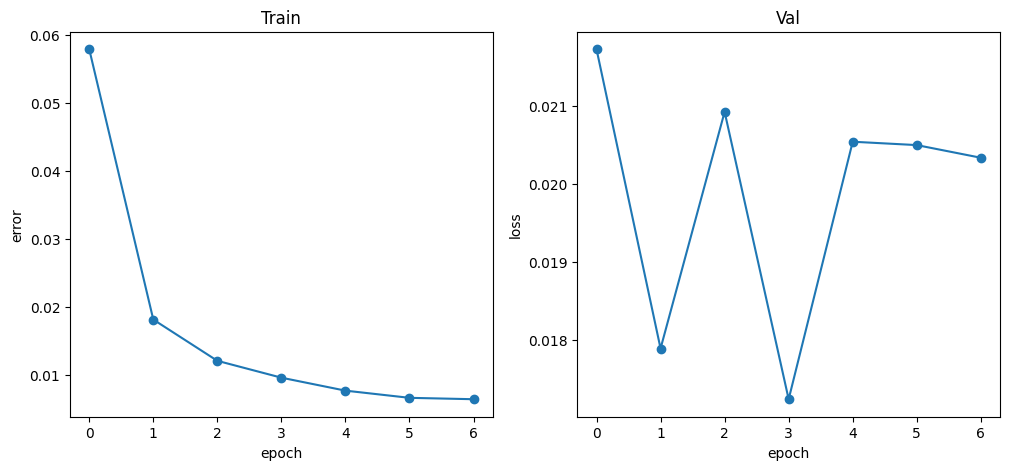

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses,marker='o')
plt.title("Train")
plt.xlabel("epoch")
plt.ylabel("error")

plt.subplot(1,2,2)
plt.plot(val_losses,marker='o')
plt.title("Val")
plt.xlabel("epoch")
plt.ylabel("loss")

### Результаты на test

Предобрабатываем данные по тест, почти точно также как это делали на train

In [ ]:
# Словарь сущностей
label2id = {'[PAD]': 0, 'O': 1, 'B-EXE': 2, 'I-EXE': 3, 'B-GUA': 4, 'I-GUA': 5}
id2label = {0:'[PAD]', 1:'O', 2:'B-EXE', 3:'I-EXE', 4:'B-GUA',5:'I-GUA'}

tensor_names = ('input_ids', 'attention_mask', 'labels')
max_len = 511

In [ ]:
def preprosses_test(data):
    sequences = {t: [] for t in tensor_names}

    encodings, labels = tokenize_sens(data)

    if len(encodings)!=0:
        for i in tqdm(range(len(labels))):
            sequence = cut_long_sequence(encodings[i],labels[i])
            for t in tensor_names:
                sequences[t].extend(sequence[t])
        
        for t in tensor_names:
            sequences[t] = np.array(sequences[t])
        return sequences,encodings[0]
    else:
        return None,None

In [ ]:
# Чистим кэш
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [ ]:
# Подгружаем лучшую модель
from transformers import BertConfig, BertForTokenClassification

config = BertConfig.from_pretrained('/content/sbert_large_nlu_ru/config.json',num_labels = 6)

state=torch.load("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/Models/Bert_NER_1.pt")
model = BertForTokenClassification.from_pretrained(pretrained_model_name_or_path=None, state_dict=state['model'], config=config)
model = model.to(device)

In [ ]:
print(len(data_test))
print(len(data_val))
print(len(data_test_without_blank))

456
150
149


In [ ]:
# Данная функция на вход принимает данные и модель и возвращает предсказанные позиции и лэйблы, а также настоящие позиции и лэйблы
def test_function_ner(data_test, model):
    postions_predicted = []
    postions_true = []

    labels_predicted = []
    labels_true = []
    model.eval()
    # Данный код содержит модель, которая выделяет сущности, однако здесь мы проходим по каждому примеру отдельно
    # и в модель тоже передается один пример, потому что этот пример может быть разбит на несколько последовательностей
    # и чтобы потом их склеить нужно в рамках одного примера 
    for i in tqdm(range(len(data_test))):
        index = i
        sequences_test,encoding = preprosses_test(data_test[i:i+1])
        if sequences_test!=None and encoding!=None:
            test_labels = []
            test_attention_mask = []
            test_input_ids = []

            for i in range(len(sequences_test['labels'])):
                test_labels.append(sequences_test['labels'][i])
                test_attention_mask.append(sequences_test['attention_mask'][i])
                test_input_ids.append(sequences_test['input_ids'][i])


            test_labels = np.array(test_labels)
            test_attention_mask = np.array(test_attention_mask)
            test_input_ids = np.array(test_input_ids)

            test_dataset = TrainDataset(test_input_ids,test_attention_mask, test_labels)
            test_dataloader = torch.utils.data.DataLoader(test_dataset,shuffle=False,batch_size=len(test_dataset),num_workers=2,pin_memory=True)

            with torch.no_grad():
                for batch_inputs, batch_att, batch_labels in tqdm(test_dataloader):
                    
                    batch_inputs = batch_inputs.to(device)
                    batch_att = batch_att.to(device)

                    outputs = model(batch_inputs, attention_mask=batch_att)
            # Выделяем лэйблы
            labels = np.argmax(outputs.logits.detach().cpu().numpy(),axis = 2)

            att_masks_union = []
            labels_union = []
            # Посделовательность может быть разбита на несколько частей, потому что она длинная.
            # Поэтому ее нужно склеить. Первым делом просто их соединяем
            for i in range(len(sequences_test['attention_mask'])):
                att_masks_union+=list(sequences_test['attention_mask'][i])
                labels_union+=list(labels[i])

            # Склеиваем лэйблы, где att_masks_union == 1, att_masks_union[i-1]!=0, это исключает первый cls токен при склейке, i!=0 исключаем cls токен

            completed_labels = []
            for i in range(len(labels_union)):
                if i!=0 and att_masks_union[i]==1 and att_masks_union[i-1]!=0:
                    completed_labels.append(labels_union[i])

            # Переводим из ids в labels
            bio_labels = []
            for i in range(len(completed_labels)):
                bio_labels.append(id2label[completed_labels[i]])

            pos_start_end = []
            label_predicted = []
            for i in range(len(bio_labels)):
                if bio_labels[i][0]=='B':
                    # Получаем индекс начала в предложении относительно токена i
                    start, _ = encoding.token_to_chars(i)
                    # Извлекаем Лэйблы
                    label_predicted.append(bio_labels[i][2:])
                    for j in range(i,len(bio_labels),1):
                        if bio_labels[j][0]=='O':
                            #Получаем индекс конца предложения относительно токена j
                            _, end = encoding.token_to_chars(j-1)
                            break
                    pos_start_end.append((start, end))

            #Если len(pos_start_end) == 0, то сущности не выделены и мы инийиализируем start=0 и end = 0
            if len(pos_start_end) == 0:
                postions_predicted.append([(0,0)])
                labels_predicted.append([])
            else:
                postions_predicted.append(pos_start_end)
                labels_predicted.append(label_predicted)

            test_start =  data_test[index]['entities'][0]['start']
            test_end = data_test[index]['entities'][0]['end']
            postions_true.append((test_start,test_end))
            labels_true.append(data_test[index]['entities'][0]['label'])
    return postions_predicted, labels_predicted, postions_true, labels_true

In [ ]:
# postions_predicted, labels_predicted, postions_true, labels_true = test_function_ner(data_test, model)

In [ ]:
# print(len(postions_true))
# print(len(postions_predicted))

In [ ]:
# print(len(labels_predicted))
# print(len(labels_true))

Если len(postions_predicted[i])>1 и лэйблы совпадают, то мы объеденяем наш промежутки, если они разные то выбираем тот который соответстует запросу

In [ ]:
def union_positions_ner(data_test, postions_predicted, labels_predicted):
    for i in range(len(postions_predicted)):
        if len(postions_predicted[i])>1:
            if labels_predicted[i][0] == labels_predicted[i][1]:
                labels_predicted[i] = [labels_predicted[i][0]]
                postions_predicted[i] = [(postions_predicted[i][0][0],postions_predicted[i][-1][1])]
            else:
                query = data_test[i]["entities"][0]['label']
                for j,lab_pred in enumerate(labels_predicted):
                    if lab_pred == query:
                        labels_predicted[i] = [labels_predicted[i][j]]
                        postions_predicted[i] = [(postions_predicted[i][j][0],postions_predicted[i][j][1])]
    return postions_predicted, labels_predicted


In [ ]:
# postions_predicted, labels_predicted = union_positions_ner(data_test, postions_predicted, labels_predicted)

Вычисляем точность и извлекаем индексы, на которых алгоритм допустил ошибку

In [ ]:
def calc_acc_ner(data_test, postions_predicted, labels_predicted, postions_true, labels_true):
    m = 0
    wrong_indexs = []
    for i in range(len(postions_true)):
        true_start = postions_true[i][0]
        true_end = postions_true[i][1]
        query = data_test[i]["entities"][0]['label']

        if len(postions_predicted[i])!=0:
            predicted_start = postions_predicted[i][0][0]
            predicted_end = postions_predicted[i][0][1]
            if predicted_start == 0 and predicted_end == 0:
                if true_start == predicted_start and true_end == predicted_end:
                    m+=1
                else:
                    wrong_indexs.append(i)
            else:
                if true_start == predicted_start and true_end == predicted_end and labels_predicted[i][0]==labels_true[i]:
                    m+=1
                else:
                    wrong_indexs.append(i)
    return m/len(postions_true), wrong_indexs

In [ ]:
# Точность на всех тестовых данных.Стоит заметить, что данные на тесте несбалансированы,
# то есть, модель обучалось без данных с start = 0 и end = 0, поэтому эти данные на которых
# она не обучаалсь я перекинул в тест. А алгоритм хорошо определяет,  start = 0 и end = 0, поэтому 
# точность получилась очень высокая
postions_predicted_all_test, labels_predicted_all_test, postions_true_all_test, labels_true_all_test = test_function_ner(data_test, model)
postions_predicted_all_test, labels_predicted_all_test = union_positions_ner(data_test, postions_predicted_all_test, labels_predicted_all_test)
acc_all_test,wrong_indexs_all_test =  calc_acc_ner(data_test, postions_predicted_all_test, labels_predicted_all_test, postions_true_all_test, labels_true_all_test)


In [ ]:
print(f"Точность на всех тестовых данных = {acc_all_test}")

Точность на всех тестовых данных = 0.8859649122807017


Результат очень хороший, но в этих тестовых данных 307 пустых, то есть start = 0 и end = 0. Непонятно насколько точно алгоритм выделяет тескт, там где он есть на самом деле. Поэтому в следующем тесте я убрал пустые примеры и оценил точность на тех примерах, в которых точно есть текст

In [ ]:
# Посмотрим на точность на тестовых данных, в этих данных нет данных с start = 0 и end = 0,
# поэтому точность и невысокая

postions_predicted_without_blank, labels_predicted_without_blank, postions_true_without_blank, labels_true_without_blank = test_function_ner(data_test_without_blank, model)
postions_predicted_without_blank, labels_predicted_without_blank = union_positions_ner(data_test_without_blank, postions_predicted_without_blank, labels_predicted_without_blank)
acc_test_without_blank,wrong_indexs_without_blank =  calc_acc_ner(data_test_without_blank, postions_predicted_without_blank, labels_predicted_without_blank, postions_true_without_blank, labels_true_without_blank)


In [ ]:
print(f"Точность на тестовый данных без данных с start = 0 и end = 0  = {acc_test_without_blank}")

Точность на тестовый данных без данных с start = 0 и end = 0  = 0.7583892617449665


In [ ]:
# Посмотрим на точноть на валидационных данных, в этих данных нет данных с start = 0 и end = 0,
# поэтому точность и невысокая. Я вывел точность на валидационных данных, чтобы показать, что
# высокая точночть на тесте это не показатель и еще при тренироке я не вычилял точность, а оценивал loss

postions_predicted_val, labels_predicted_val, postions_true_val, labels_true_val = test_function_ner(data_val, model)
postions_predicted_val, labels_predicted_val = union_positions_ner(data_val, postions_predicted_val, labels_predicted_val)
acc_val,wrong_indexs_val =  calc_acc_ner(data_val, postions_predicted_val, labels_predicted_val, postions_true_val, labels_true_val)


In [ ]:
print(f"Точность на val = {acc_val}")

Точность на val = 0.7


### Исследование неправильно выделенных предложений

In [ ]:
for i,wrong_index in enumerate(wrong_indexs_all_test):
    print(f"Predicted text--{data_test[wrong_index]['text'][postions_predicted_all_test[wrong_index][0][0]:postions_predicted_all_test[wrong_index][0][1]]}--{postions_predicted_all_test[wrong_index][0][0]},{postions_predicted_all_test[wrong_index][0][1]}")
    print(f"True text--{data_test[wrong_index]['text'][postions_true_all_test[wrong_index][0]:postions_true_all_test[wrong_index][1]]}--{postions_true_all_test[wrong_index][0]},{postions_true_all_test[wrong_index][1]}")
        
    print()
    print()

Predicted text--Размер обеспечения гарантийных обязательств составляет 5% от начальной максимальной цены Контракта, что составляет _______ (_______) рублей--1118,1257
True text--Размер обеспечения гарантийных обязательств составляет 5% от начальной максимальной цены Контракта, что составляет _______ (_______) рублей _________ (_____)--1118,1275


Predicted text--Размер обеспечения гарантийных обязательств: 1% от начальной (максимальной) цены контракта (договора), что составляет 125 350,10 рублей (--1431,1568
True text--согласно п. 3.1. Договора Поставщик представляет Заказчику обеспечение гарантийных обязательств на поставленные товары. Размер обеспечения гарантийных обязательств: 1% от начальной (максимальной) цены контракта (договора), что составляет 125 350,10 рублей--1311,1566


Predicted text--Размер обеспечения исполнения Контракта составляет 5 (пять) процентов от цены Контракта и составляет ____________ руб. _____--1045,1169
True text--Размер обеспечения исполнения Контракта сос

Можно заметить, что в большинстве случаев, на которых модель ошиблась, она правильно определяет начало, но неверно конец: либо выделяет чуть-чуть больше информации или чуть чуть меньше

## Test

In [ ]:
# Чистим кэш
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [ ]:
# Словарь сущностей
label2id = {'[PAD]': 0, 'O': 1, 'B-EXE': 2, 'I-EXE': 3, 'B-GUA': 4, 'I-GUA': 5}
id2label = {0:'[PAD]', 1:'O', 2:'B-EXE', 3:'I-EXE', 4:'B-GUA',5:'I-GUA'}

tensor_names = ('input_ids', 'attention_mask', 'labels')
max_len = 511

Подгружаем лучшую модель

In [ ]:
from transformers import BertConfig, BertForTokenClassification

config = BertConfig.from_pretrained('/content/sbert_large_nlu_ru/config.json',num_labels = 6)

state=torch.load("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/Models/Bert_NER_1.pt")
model = BertForTokenClassification.from_pretrained(pretrained_model_name_or_path=None, state_dict=state['model'], config=config)
model = model.to(device)

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self,data_input, data_att):
        self.data_input = data_input
        self.data_att = data_att

    def __len__(self):
        return len(self.data_input)
    
    def __getitem__(self,idx):
        return torch.from_numpy(self.data_input[idx]),torch.from_numpy(self.data_att[idx])

In [ ]:
def preprosses_inf(data):
    sequences = {t: [] for t in tensor_names}

    text = data['text']
    encoding = tokenizer(text,add_special_tokens=False)[0]

    sequence = cut_long_sequence(encoding)

    for t in tensor_names:
        sequence[t] = np.array(sequence[t])

    return sequence,encoding

In [ ]:
test_df = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/dataset/test.json")

In [ ]:
test_df.head(3)

,id,text,label
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта


In [ ]:
len(test_df)

318

Дальше подготавливаем данные в модель. Данные подготавливаются почти точно также

In [ ]:
normal_labels = []
for i in range(len(test_df)):
    if test_df['label'][i] == "обеспечение исполнения контракта":
        normal_labels.append("EXE")
    elif test_df['label'][i] == "обеспечение гарантийных обязательств":
        normal_labels.append("GUA")


test_df['normal_labels'] = normal_labels

Inf_data = test_df

Inf_data = Inf_data.reset_index()

data_inf = []
for i in range(len(Inf_data)):
    data = {}
    data['text'] = Inf_data['text'][i]
    data['entities'] = []
    lab = Inf_data['normal_labels'][i]

    data['entities'].append({"label":lab})
    data_inf.append(data)


In [ ]:
model.eval()
postions_predicted = []
postions_true = []
labels_predicted = []
# Данный код содержит модель, которая выделяет сущности, однако здесь мы проходим по каждому примеру отдельно
# и в модель тоже передается один пример, потому что этот пример может быть разбит на несколько последовательностей
# и чтобы потом их склеить нужно в рамках одного примера 

for i in tqdm(range(len(data_inf))):
    index = i
    sequences_test,encoding = preprosses_inf(data_inf[i])

    test_labels = []
    test_attention_mask = []
    test_input_ids = []

    for i in range(len(sequences_test['attention_mask'])):
        test_attention_mask.append(sequences_test['attention_mask'][i])
        test_input_ids.append(sequences_test['input_ids'][i])


    test_attention_mask = np.array(test_attention_mask)
    test_input_ids = np.array(test_input_ids)

    test_dataset = TestDataset(test_input_ids,test_attention_mask)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,shuffle=False,batch_size=len(test_dataset),num_workers=2,pin_memory=True)
    
    with torch.no_grad():
        for batch_inputs, batch_att in tqdm(test_dataloader):
            
            batch_inputs = batch_inputs.to(device)
            batch_att = batch_att.to(device)

            outputs = model(batch_inputs, attention_mask=batch_att)
    # Выделяем лэйблы
    labels = np.argmax(outputs.logits.detach().cpu().numpy(),axis = 2)

    att_masks_union = []
    labels_union = []
    # Посделовательность может быть разбита на несколько частей, потому что она длинная.
    # Поэтому ее нужно склеить. Первым делом просто их соединяем

    for i in range(len(sequences_test['attention_mask'])):
        att_masks_union+=list(sequences_test['attention_mask'][i])
        labels_union+=list(labels[i])

    # Склеиваем лэйблы, где att_masks_union == 1, att_masks_union[i-1]!=0, это исключает первый cls токен при склейке, i!=0 исключаем cls токен
    completed_labels = []
    for i in range(len(labels_union)):
        if i!=0 and att_masks_union[i]==1 and att_masks_union[i-1]!=0:
            completed_labels.append(labels_union[i])

    # Переводим из ids в labels
    bio_labels = []
    for i in range(len(completed_labels)):
        bio_labels.append(id2label[completed_labels[i]])

    pos_start_end = []
    label_predicted = []
    for i in range(len(bio_labels)):
        if bio_labels[i][0]=='B':
            # Получаем индекс начала в предложении относительно токена i
            start, _ = encoding.token_to_chars(i)
            # Извлекаем Лэйблы
            label_predicted.append(bio_labels[i][2:])
            for j in range(i,len(bio_labels),1):
                if bio_labels[j][0]=='O':
                    #Получаем индекс конца предложения относительно токена j
                    _, end = encoding.token_to_chars(j-1)
                    break

            pos_start_end.append((start, end))

    #Если len(pos_start_end) == 0, то сущности не выделены и мы инийиализируем start=0 и end = 0
    if len(pos_start_end) == 0:
        postions_predicted.append([(0,0)])
        labels_predicted.append([])
    else:
        postions_predicted.append(pos_start_end)
        labels_predicted.append(label_predicted)


In [ ]:
test_df["answer_start"] = 0
test_df["answer_end"] = 0
test_df["answer_text"] = 0

### Формирование данных под результат

In [ ]:
for i in range(len(postions_predicted)):

    # Если start = 0 и end = 0, то answer_start = 0, answer_end = 0, answer_text =""
    if postions_predicted[i][0][0]==0 and postions_predicted[i][0][1]==0:
        test_df['answer_start'][i]=0
        test_df['answer_end'][i]=0
        test_df['answer_text'][i]=""   
        
    elif len(postions_predicted[i])==1:
        query = data_inf[i]["entities"][0]['label']
        # Если запрос, который был передан, равен лэйблу, то извлекаем и добавляем start, end, если нет, то answer_start = 0, answer_end = 0, answer_text =""
        if query == labels_predicted[i][0]:
            test_df['answer_start'][i]=postions_predicted[i][0][0]
            test_df['answer_end'][i]=postions_predicted[i][0][1]
            test_df['answer_text'][i]=data_inf[i]['text'][postions_predicted[i][0][0]:postions_predicted[i][0][1]]
        else:
            test_df['answer_start'][i]=0
            test_df['answer_end'][i]=0
            test_df['answer_text'][i]=""

    # Если len(postions_predicted[i])>1, то их нужно объеденить
    elif len(postions_predicted[i])>1:
        #Если labels_predicted[i][0] == labels_predicted[i][1], то просто из первой postions_predicted достаем start, а из последней postions_predicted, end
        if labels_predicted[i][0] == labels_predicted[i][1]:
            labels_predicted[i] = [labels_predicted[i][0]]
            postions_predicted[i] = [(postions_predicted[i][0][0],postions_predicted[i][-1][1])]
            query = data_inf[i]["entities"][0]['label']
            if query == labels_predicted[i][0]:
                test_df['answer_start'][i]=postions_predicted[i][0][0]
                test_df['answer_end'][i]=postions_predicted[i][0][1]
                test_df['answer_text'][i]=data_inf[i]['text'][postions_predicted[i][0][0]:postions_predicted[i][0][1]]
            else:
                test_df['answer_start'][i]=0
                test_df['answer_end'][i]=0
                test_df['answer_text'][i]=""
        else:
            #Если labels_predicted[i][0] != labels_predicted[i][1], то ущем те позиции которые соответствуют запросу
            query = data_inf[i]["entities"][0]['label']
            for j,lab_pred in enumerate(labels_predicted):
                if lab_pred == query:
                    labels_predicted[i] = [labels_predicted[i][j]]
                    postions_predicted[i] = [(postions_predicted[i][j][0],postions_predicted[i][j][1])]
                    test_df['answer_start'][i]=postions_predicted[i][0][0]
                    test_df['answer_end'][i]=postions_predicted[i][0][1]
                    test_df['answer_text'][i]=data_inf[i]['text'][postions_predicted[i][0][0]:postions_predicted[i][0][1]]
    else:
        test_df['answer_start'][i]=0
        test_df['answer_end'][i]=0
        test_df['answer_text'][i]=""

In [ ]:
test_df

,id,text,label,normal_labels,answer_start,answer_end,answer_text
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,EXE,1283,1393,Размер обеспечения исполнения Контракта состав...
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,EXE,1291,1337,Размер обеспечения исполнения контракта 10.00%
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,EXE,1300,1412,Размер обеспечение исполнения контракта устана...
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта,EXE,1312,1424,Размер обеспечение исполнения контракта устана...
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта,EXE,1314,1426,Размер обеспечение исполнения контракта устана...
...,...,...,...,...,...,...,...
313,854936033,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,обеспечение гарантийных обязательств,GUA,0,0,
314,576390745,Часть III Проект договора Договор №______ пост...,обеспечение гарантийных обязательств,GUA,1301,1425,Размер обеспечения гарантийных обязательств не...
315,323745820,УТВЕРЖДАЮ Председатель единой комиссии по осущ...,обеспечение гарантийных обязательств,GUA,0,0,
316,712286194,Версия с 04.07.2022 года У Т В Е Р Ж Д А Ю «Го...,обеспечение гарантийных обязательств,GUA,0,0,


Формируем список словарей со всеми нужными данными

In [ ]:
final_json = []
for i in range(len(test_df)):
    f_data = {}
    f_data["id"] = test_df['id'][i]
    f_data["text"]  = test_df['text'][i]
    f_data["label"] = test_df['label'][i]
    f_data["extracted_part"] = {
        'text':[test_df['answer_text'][i]],
        'answer_start':[test_df['answer_start'][i]],
        'answer_end':[test_df['answer_end'][i]]
    }
    final_json.append(f_data)

In [ ]:
len(final_json)

318

In [ ]:
test_df = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/dataset/test.json")

In [ ]:
train_df.head(2)

,index,id,text,label,extracted_part,normal_labels
0,0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...,EXE
1,1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,{'text': ['Поставщик должен предоставить обесп...,EXE


Формируем колонку extracted_part

In [ ]:
test_df["extracted_part"] = 0

In [ ]:
for i in range(len(final_json)):
    if final_json[i]["extracted_part"]['answer_start'][0]==0 and final_json[i]["extracted_part"]['answer_end'][0]==0:
        final_json[i]["extracted_part"]['text'] = [""]
        test_df["extracted_part"][i] = final_json[i]["extracted_part"]
    else:
        test_df["extracted_part"][i] = final_json[i]["extracted_part"]

In [ ]:
test_df

,id,text,label,extracted_part
0,762883279,МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание ус...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения Контр...
1,311837655,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,{'text': ['Размер обеспечения исполнения контр...
2,540954893,Идентификационный код закупки: 222633005300163...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...
3,274660397,Идентификационный код закупки: 222631202689463...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...
4,732742591,Идентификационный код закупки: 222637800031163...,обеспечение исполнения контракта,{'text': ['Размер обеспечение исполнения контр...
...,...,...,...,...
313,854936033,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_en..."
314,576390745,Часть III Проект договора Договор №______ пост...,обеспечение гарантийных обязательств,{'text': ['Размер обеспечения гарантийных обяз...
315,323745820,УТВЕРЖДАЮ Председатель единой комиссии по осущ...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_en..."
316,712286194,Версия с 04.07.2022 года У Т В Е Р Ж Д А Ю «Го...,обеспечение гарантийных обязательств,"{'text': [''], 'answer_start': [0], 'answer_en..."


Сохраняем

In [ ]:
with open('/content/predictions.json', 'w', encoding='utf-8') as file:
    test_df.to_json(file,orient = "records", force_ascii=False)


# Исследование резульатов двух моделей

In [ ]:
df_ner = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/All_predictions/predictionsNER_format.json")
df_qa = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/All_predictions/predictionsQA_format_1.json")
test_df = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/dataset/test.json")


Проверим, что id совпадают

In [ ]:
(df_ner["id"]==test_df["id"]).all()

True

In [ ]:
(df_qa["id"]==test_df["id"]).all()

True

In [ ]:
print(len(df_ner))
print(len(df_qa))
print(len(test_df))

318
318
318


In [ ]:
start_end_pos_ner = []
start_end_pos_qa = []

In [ ]:
# Извлечем из рузультатов NER и QA extracted_text, answer_start, answer_end
for i in range(len(test_df)):
    extr_text_ner = df_ner['extracted_part'][i]['text'][0]
    start_ner = df_ner['extracted_part'][i]['answer_start'][0]
    end_ner = df_ner['extracted_part'][i]['answer_end'][0]

    extr_text_qa = df_qa['extracted_part'][i]['text'][0]
    start_qa = df_qa['extracted_part'][i]['answer_start'][0]
    end_qa = df_qa['extracted_part'][i]['answer_end'][0]

    start_end_pos_ner.append([extr_text_ner,start_ner,end_ner])
    start_end_pos_qa.append([extr_text_qa,start_qa,end_qa])

In [ ]:
print(len(start_end_pos_qa))
print(len(start_end_pos_ner))

318
318


In [ ]:
start_end_pos_qa[0]

['Размер обеспечения исполнения Контракта составляет _______ рублей ____ копеек (5 процентов от цены контракта).',
 1283,
 1393]

In [ ]:
# Посчитаем количество совпадений между двумя решениями и выделим индексы, на которых модели дали разные результаты
m=0
not_equal_digits = []
right_di = []
for i in range(len(start_end_pos_ner)):
    if start_end_pos_qa[i][0]==start_end_pos_ner[i][0] and start_end_pos_qa[i][1]==start_end_pos_ner[i][1] and start_end_pos_qa[i][2]==start_end_pos_ner[i][2]:
        m+=1
        right_di.append(i)
    else:
        not_equal_digits.append(i)
print(f"Процент совпадений между двумя результатами = {m/len(start_end_pos_ner)}")

Процент совпадений между двумя результатами = 0.7641509433962265


In [ ]:
len(not_equal_digits)

75

In [ ]:
for i in not_equal_digits:
    print(f"QA:{start_end_pos_qa[i][0]}--  {start_end_pos_qa[i][1]}  {start_end_pos_qa[i][2]}")
    print(f"NER:{start_end_pos_ner[i][0]}--  {start_end_pos_ner[i][1]}  {start_end_pos_ner[i][2]}")
    print()
    print()

QA:Обеспечение исполнения настоящего Контракта предоставляется Поставщиком на сумму 10% от начальной (максимальной) цены Контракта, что составляет 170 417--  1303  1454
NER:Обеспечение исполнения настоящего Контракта предоставляется Поставщиком на сумму 10% от начальной (максимальной) цены Контракта--  1303  1430


QA:Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 10 % начальной (максимальной) цены контракта--  1010  1162
NER:Поставщик при заключении Контракта должен предоставить Заказчику обеспечение исполнения Контракта в размере 10 % начальной (максимальной) цены контракта – 10 080,00 руб.--  1010  1179


QA:Размер обеспечения исполнения контракта 20% от начальной (максимальной) цены контракта--  1278  1364
NER:--  0  0


QA:Сумма обеспечения исполнения Контракта устанавливается в размере 5% от цены Контракта(а--  1251  1338
NER:Сумма обеспечения исполнения Контракта устанавливается в размере 5% от цены Контракта--  1251  

Как видно многие примеры, на которых модели дают разные результаты,друг на друга очень похожи, то есть у них совпадает начало, но отличается конец выделенного текста

# Вывод 

В резульате работы были реализованы и обучены две модели, одна это BertForQuestionAnswering и BertForTokenClassification. В результате исследования результатов было выяснено, что процент совпадения между ними 76%. Примеры на которых у них разные ответы, эти ответы очень похожи, то есть у многих из них одно начало, но немного отличается конец. В качестве predictions был выбран результат с BertForQuestionAnswering, потому что результаты на тесте выше, в точность на тесте BertForQuestionAnswering = 0.77, а BertForTokenClassification = 0.75

# Check results

In [ ]:
start_end_pos_ner = []
start_end_pos_qa = []
start_end_true = []

In [ ]:
df_ner = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/All_predictions/predictionsNER_format.json")
df_qa = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/All_predictions/predictionsQA_format_1.json")
test_df = pd.read_json("/content/drive/MyDrive/NLP_2023_mag/Contur/nlp_test_task_2023/nlp_test_task_2023/All_predictions/test_with_labels.json")


In [ ]:
# Извлечем из рузультатов NER и QA extracted_text, answer_start, answer_end
for i in range(len(test_df)):
    extr_text_ner = df_ner['extracted_part'][i]['text'][0]
    start_ner = df_ner['extracted_part'][i]['answer_start'][0]
    end_ner = df_ner['extracted_part'][i]['answer_end'][0]

    extr_text_qa = df_qa['extracted_part'][i]['text'][0]
    start_qa = df_qa['extracted_part'][i]['answer_start'][0]
    end_qa = df_qa['extracted_part'][i]['answer_end'][0]

    extr_text_true = test_df['extracted_part'][i]['text'][0]
    start_true = test_df['extracted_part'][i]['answer_start'][0]
    end_true = test_df['extracted_part'][i]['answer_end'][0]

    start_end_pos_ner.append([extr_text_ner,start_ner,end_ner])
    start_end_pos_qa.append([extr_text_qa,start_qa,end_qa])
    start_end_true.append([extr_text_true,start_true,end_true])

In [ ]:
print(len(start_end_pos_ner))
print(len(start_end_pos_qa))
print(len(start_end_true))

318
318
318


In [ ]:
n_r = 0
for i in range(len(start_end_true)):
    if start_end_pos_ner[i][1]==start_end_true[i][1] and start_end_pos_ner[i][2]==start_end_true[i][2]:
        n_r+=1
n_r/len(start_end_true)

0.7830188679245284

In [ ]:
n_r = 0
for i in range(len(start_end_true)):
    if start_end_pos_qa[i][1]==start_end_true[i][1] and start_end_pos_qa[i][2]==start_end_true[i][2]:
        n_r+=1
n_r/len(start_end_true)

0.7924528301886793